In [1]:
import pandas as pd
df = pd.read_csv("df_combine.csv")

# <h1>EDA-ACF 以及 PACF</h1>

In [6]:
from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf
import matplotlib.pyplot as plt

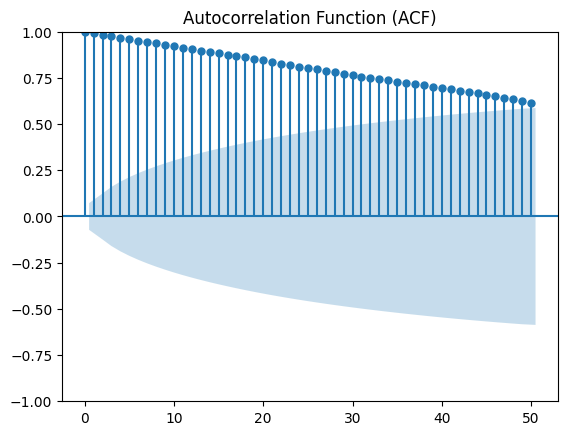

In [7]:
#計算ACF
plot_acf(df['close'], lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

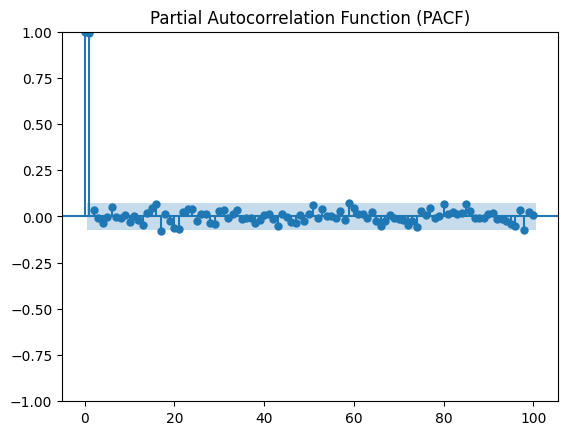

In [8]:
#計算PACF
plot_pacf(df['close'], lags=100)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
# 檢查原始數列是否平穩
result = adfuller(df['close'])
print('ADF 檢定 p-value:', result[1])


ADF 檢定 p-value: 0.5625027681389074
